<a href="https://colab.research.google.com/github/faizput/Weed-Image-Processing-FYP-22-23/blob/main/Model_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **GDrive Mount**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **File Renaming**
Function to rename file into a standardized name

- Renamed to Broad(no.).png

In [ ]:
# importing os module
import os

# Function to rename multiple files
def main():

    folder = '/content/drive/MyDrive/Local Weed/Broad'
    for count, filename in enumerate(os.listdir(folder)):
        dst = f"Broad{str(count)}.png"
        src =f"{folder}/{filename}"  # foldername/filename, if .py file is outside folder
        dst =f"{folder}/{dst}"

        # rename() function will
        # rename all the files
        os.rename(src, dst)

# Driver Code
if __name__ == '__main__':

    # Calling main() function
    main()

- Renamed to Broad(no.).png

In [ ]:
# importing os module
import os

# Function to rename multiple files
def main():

    folder = '/content/drive/MyDrive/Local Weed/Narrow'
    for count, filename in enumerate(os.listdir(folder)):
        dst = f"Narrow{str(count)}.png"
        src =f"{folder}/{filename}"  # foldername/filename, if .py file is outside folder
        dst =f"{folder}/{dst}"

        # rename() function will
        # rename all the files
        os.rename(src, dst)

# Driver Code
if __name__ == '__main__':

    # Calling main() function
    main()

# **Data Splitting**

Split the dataset into three folder (validation, test and train) according given ratio / fixed number

In [ ]:
# https://youtu.be/C6wbr1jJvVs - video tutorial
#!pip install split-folders
import splitfolders  # or import split_folders

input_folder = '/content/drive/MyDrive/Ground Data'

# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
#Train, val, test
splitfolders.ratio(input_folder, output="/content/drive/MyDrive/Local Weed/Data",
                   seed=42, ratio=(.7, .15, .15),
                   group_prefix=None) # default values


# Split val/test with a fixed number of items e.g. 100 for each set.
# To only split into training and validation set, use a single number to `fixed`, i.e., `10`.
# enable oversampling of imbalanced datasets, works only with fixed
#splitfolders.fixed(input_folder, output="/content/drive/MyDrive/Image Classification2",
#                  seed=42, fixed=(.7, .2, .1),
#                  oversample=False, group_prefix=None)

Copying files: 1824 files [00:22, 80.41 files/s]


# **Installing Libraries**

In [ ]:
import pandas as pd #data manipulation and analysis
import numpy as np #numerical operation
import tensorflow as tf #ml and dl
import matplotlib.pyplot as plt #data visualization
import matplotlib.image as mpimg #image handling
import seaborn as sns #statistical data visualization
import pathlib # file paths
import random # generate random numbers
import os # interact with operating system

from tensorflow.keras.preprocessing import image_dataset_from_directory #create dataset from image directory
from tensorflow.keras.layers.experimental import preprocessing #data pre-processing
from tensorflow.keras.applications import VGG16 #import VGG16 pre-trained model
from tensorflow.keras.optimizers import Adam #Adam optimizer / model optimization
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, roc_auc_score, confusion_matrix #evaluation matrix
from sklearn.metrics import classification_report #classification report
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D # layers to build custom architecture
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping #callback function for model training
from tensorflow.keras import Model #import model class
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D #for model architecture building

#Suppressing Warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #environment variable for TensorFlow warning suppression

In [ ]:
tf.keras.backend.clear_session() #used to clear current Keras session

# **Pre-Processing**

The Train & Test Path

In [ ]:
train_path = '/content/drive/MyDrive/Local Weed/Dataset/train'
validation_path = '/content/drive/MyDrive/Local Weed/Dataset/val'

Get the data label

In [ ]:
labels = []
for i in os.listdir(train_path):
    if i[-3:]!='txt':
        labels+=[i]

labels

['Narrow', 'Broad']

Load Random Images by classes

In [ ]:
def load_random_imgs_from_folder(folder,label):
  plt.figure(figsize=(20,20))
  for i in range(4):
    file = random.choice(os.listdir(folder))
    image_path = os.path.join(folder, file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,4,i+1)
    ax.title.set_text(label)
    plt.xlabel(f'Name: {file} , "Size: {img.shape}"')
    plt.imshow(img)

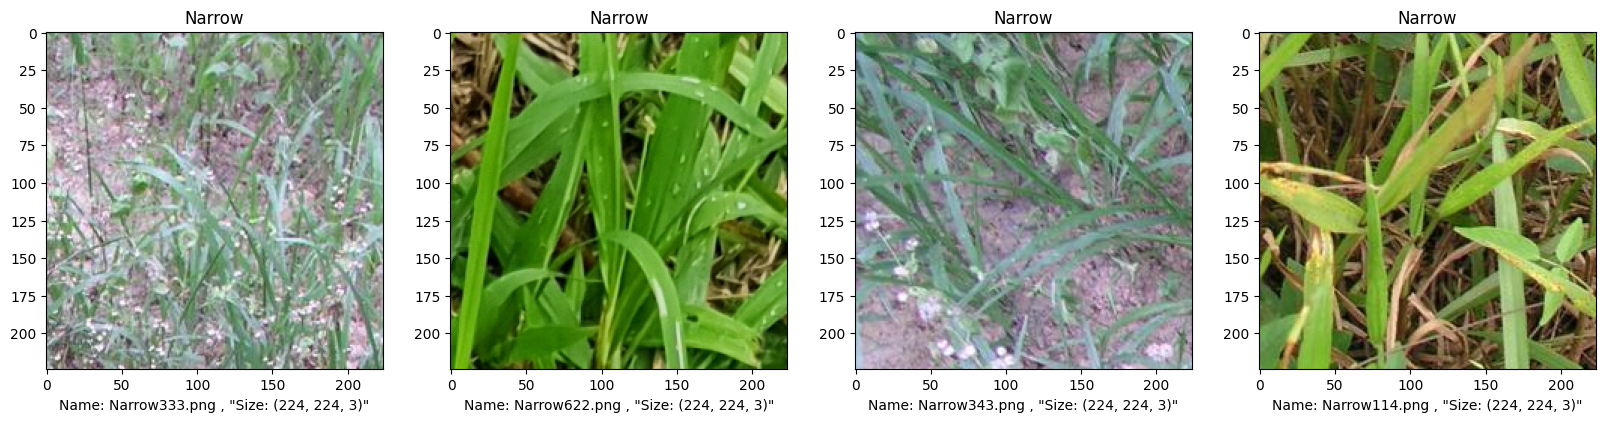

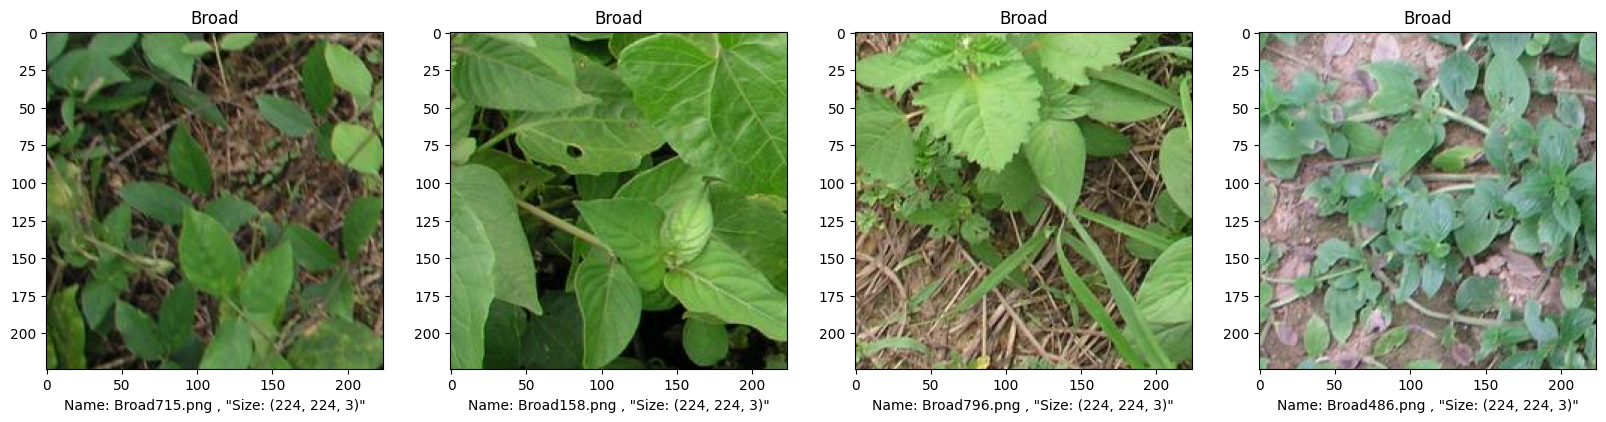

In [ ]:
for label in labels:
    load_random_imgs_from_folder(f"{train_path}/{label}",label)

The images from the dataset are already 224 x 224 it is picked as the size for model training

In [ ]:
img_size = 224
batch = 32

# **Image Augmentation**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
train_datagen = ImageDataGenerator(rotation_range = 30,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.15,
                                   zoom_range = 0.15,
                                   horizontal_flip = True,
                                   fill_mode = 'nearest'
                                  )

test_val_datagen = ImageDataGenerator()

In [ ]:
train_generator = train_datagen.flow_from_directory(directory = train_path,
                                                    batch_size = batch,
                                                    class_mode = "categorical",
                                                    shuffle = True,
                                                    target_size = (img_size,img_size)
                                                    )

val_generator = test_val_datagen.flow_from_directory(directory = validation_path,
                                                    batch_size = 1,
                                                    shuffle=False,
                                                    class_mode = "categorical",
                                                    target_size = (img_size,img_size)
                                                    )

Found 1276 images belonging to 2 classes.
Found 273 images belonging to 2 classes.


# **Modelling**

The used is a pre-trained VGG16 through transfer learning with keras.

*Extra layers can be added to model*

In [ ]:
from tensorflow.keras.applications import VGG16

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False,
                            input_shape=(img_size, img_size,3),
                         pooling='avg')

# freeze extraction layers
base_model.trainable = False

# add custom top layers
x = base_model.output
x = Dense(128 , activation='relu')(x)
x = Dense(128 , activation='relu')(x)
predictions = Dense(len(labels), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)


Entire model overview

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png')

Callback to save the best model during training

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
callbacks = [ModelCheckpoint('model.hdf5',save_best_only=True),]

In [ ]:
opt = Adam(learning_rate=0.001)
model.compile(
  loss='categorical_crossentropy',
  optimizer=opt,
  metrics=['accuracy']
)

# **Model Training**

In [ ]:
history = model.fit(train_generator,
                    epochs = 10,
                    validation_data = val_generator,
                    verbose = 1,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                                patience=2,
                                                                restore_best_weights=True)]
                   )

Epoch 1/10
40/40 [==============================] - 990s 25s/step - loss: 0.2346 - accuracy: 0.9169 - val_loss: 0.0855 - val_accuracy: 0.9634
Epoch 2/10
40/40 [==============================] - 999s 25s/step - loss: 0.0780 - accuracy: 0.9734 - val_loss: 0.0652 - val_accuracy: 0.9780
Epoch 3/10
40/40 [==============================] - 999s 25s/step - loss: 0.0490 - accuracy: 0.9843 - val_loss: 0.0659 - val_accuracy: 0.9670
Epoch 4/10
40/40 [==============================] - 959s 24s/step - loss: 0.0461 - accuracy: 0.9843 - val_loss: 0.0638 - val_accuracy: 0.9744
Epoch 5/10
40/40 [==============================] - 975s 25s/step - loss: 0.0531 - accuracy: 0.9804 - val_loss: 0.0800 - val_accuracy: 0.9780
Epoch 6/10
40/40 [==============================] - 931s 23s/step - loss: 0.0335 - accuracy: 0.9898 - val_loss: 0.0596 - val_accuracy: 0.9817
Epoch 7/10
40/40 [==============================] - 944s 24s/step - loss: 0.0490 - accuracy: 0.9835 - val_loss: 0.0675 - val_accuracy: 0.9744
Epoch 

In [ ]:
#save the model
model.save('/content/drive/MyDrive/Local Weed/Model/model VGG16-10-32.h5')